<a href="https://colab.research.google.com/github/Seouyang/Today-I-Learned/blob/master/DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DCGAN

In [15]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import imageio
from IPython.display import HTML

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torchvision.utils import make_grid

In [16]:
def vis_image(image):
    plt.imshow(image[0].detach().cpu().numpy(),cmap='gray')
    plt.show()

In [17]:
def save_gif(training_progress_images, images):
    img_grid = make_grid(images.data)
    img_grid = np.transpose(img_grid.detach().cpu().numpy(), (1, 2, 0))
    img_grid = 255. * img_grid 
    img_grid = img_grid.astype(np.uint8)
    training_progress_images.append(img_grid)
    imageio.mimsave('/gdrive/My Drive/img_align_celeba/training_progress.gif', training_progress_images)
    return training_progress_images

In [18]:
def vis_gif(training_progress_images):
    fig = plt.figure()
    
    ims = []
    for i in range(len(training_progress_images)):
        im = plt.imshow(training_progress_images[i], animated=True)
        ims.append([im])

    ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)
    
    html = ani.to_html5_video()
    HTML(html)

In [19]:
def plot_gif(training_progress_images, plot_length=10):
    plt.close()
    fig = plt.figure()
    
    total_len = len(training_progress_images)
    for i in range(plot_length):
        im = plt.imshow(training_progress_images[int(total_len/plot_length)*i])
        plt.show()

In [39]:
def save_image_list(dataset, real):
    if real:
        base_path = '/gdrive/My Drive/img_align_celeba/img/real'
    else:
        base_path = '/gdrive/My Drive/img_align_celeba/img/fake'
    
    dataset_path = []
    
    for i in range(len(dataset)):
        save_path =  f'{base_path}/image_{i}.png'
        dataset_path.append(save_path)
        vutils.save_image(dataset[i], save_path)
    
    return base_path

In [21]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [22]:
!mkdir data_faces && wget https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip 

mkdir: cannot create directory ‘data_faces’: File exists


In [23]:
import zipfile

with zipfile.ZipFile('celeba.zip', 'r') as zip_ref:
  zip_ref.extractall('data_faces/')

In [24]:
root = 'data_faces/img_align_celeba'
img_list = os.listdir(root)
print(len(img_list))

202599


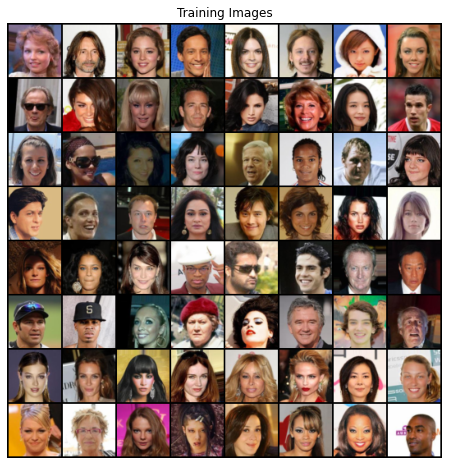

In [25]:
dataroot = './data_faces'
ngpu = 1
dataset = dset.ImageFolder(root= dataroot,
                           transform=transforms.Compose([
                                    transforms.Resize(64), 
                                    transforms.CenterCrop(64), 
                                    transforms.ToTensor(), 
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                    ]))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True, num_workers=2, drop_last=True)

device = torch.device('cuda:0' if (torch.cuda.is_available() and ngpu > 0) else 'cpu')

real_batch = next(iter(dataloader))
plt.figure(figsize=(8, 8))
plt.axis('off')
plt.title('Training Images')
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(), (1, 2, 0)))

In [26]:
nc = 3 #number of channels, RGB
nz = 100 #input noise dimension
ngf = 64 #number of generator filters
ndf = 64 #number of discriminator filters

class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()
    self.main = nn.Sequential(
        nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
        nn.BatchNorm2d(ngf * 8),
        nn.ReLU(True),
        nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ngf * 4),
        nn.ReLU(True),
        nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ngf * 2),
        nn.ReLU(True),
        nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ngf),
        nn.ReLU(True),
        nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
        nn.Tanh()
    )

  def forward(self, input):
    output = self.main(input)
    return output

In [27]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.main = nn.Sequential(
        nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ndf * 2),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ndf * 4),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ndf * 8),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
        nn.Sigmoid()
    )

  def forward(self, input):
    output = self.main(input)
    return output.view(-1, 1).squeeze(1)

In [29]:
if not os.path.exists('/gdrive/My Drive/img_align_celeba'):
    os.mkdir('/gdrive/My Drive/img_align_celeba')

if not os.path.exists('/gdrive/My Drive/img_align_celeba/checkpoint'):
    os.mkdir('/gdrive/My Drive/img_align_celeba/checkpoint')
    
if not os.path.exists('/gdrive/My Drive/img_align_celeba/dataset'):
    os.mkdir('/gdrive/My Drive/img_align_celeba/dataset')
    
if not os.path.exists('/gdrive/My Drive/img_align_celeba/img'):
    os.mkdir('/gdrive/My Drive/img_align_celeba/img')
    
if not os.path.exists('/gdrive/My Drive/img_align_celeba/img/real'):
    os.mkdir('/gdrive/My Drive/img_align_celeba/img/real')

if not os.path.exists('/gdrive/My Drive/img_align_celeba/img/fake'):
    os.mkdir('/gdrive/My Drive/img_align_celeba/img/fake')

In [30]:
netG = Generator().cuda()
netD = Discriminator().cuda()

optimizerG = optim.Adam(netG.parameters(), lr=0.0002)
optimizerD = optim.Adam(netD.parameters(), lr=0.0002)

In [33]:
fixed_noise = torch.randn(128, nz, 1, 1).cuda()
criterion = nn.BCELoss()
n_epoch = 3
training_progress_images_list = []

for epoch in range(n_epoch):
  for i, (data, _) in enumerate(dataloader):
    netD.zero_grad()
    data = data.cuda()
    batch_size = data.size(0)
    label = torch.ones((batch_size,)).cuda()
    output = netD(data)
    errD_real = criterion(output, label)
    D_x = output.mean().item()

    noise = torch.randn(batch_size, nz, 1, 1).cuda()
    fake = netG(noise)
    label = torch.zeros((batch_size,)).cuda()
    output = netD(fake.detach())
    errD_fake = criterion(output, label)
    D_G_z1 = output.mean().item()

    errD = errD_real + errD_fake
    errD.backward()
    optimizerD.step()

    netG.zero_grad()
    label = torch.ones((batch_size,)).cuda()
    output = netD(fake)
    errG = criterion(output, label)
    D_G_z2 = output.mean().item()

    errG.backward()
    optimizerG.step()
  
  print('[%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f' % (epoch, n_epoch, errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

  fake = netG(fixed_noise)
  training_progress_images_list = save_gif(training_progress_images_list, fake)
  torch.save(netG.state_dict(), '/gdrive/My Drive/img_align_celeba/checkpoint/netG_epoch_%d.pth' % (epoch))
  torch.save(netD.state_dict(), '/gdrive/My Drive/img_align_celeba/checkpoint/netD_epoch_%d.pth' % (epoch))

[0/3] Loss_D: 0.0841 Loss_G: 7.1966 D(x): 0.9400 D(G(z)): 0.0026 / 0.0087
[1/3] Loss_D: 0.0085 Loss_G: 9.6618 D(x): 0.9955 D(G(z)): 0.0028 / 0.0006
[2/3] Loss_D: 0.0807 Loss_G: 10.5604 D(x): 0.9560 D(G(z)): 0.0008 / 0.0005


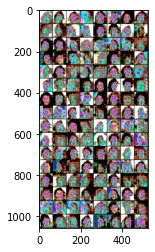

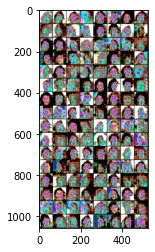

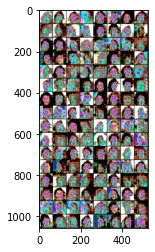

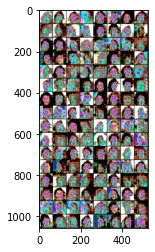

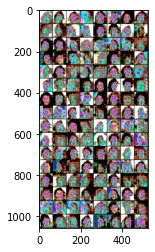

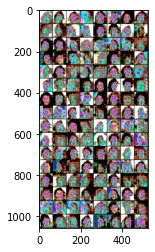

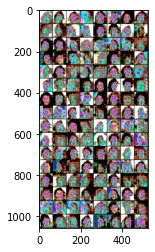

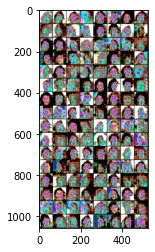

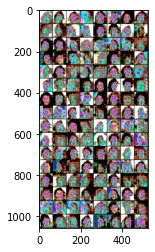

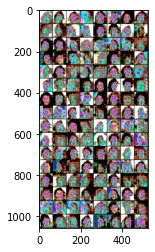

In [34]:
plot_gif(training_progress_images_list)

In [35]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1InzR1qylS3Air4IvpS9CoamqJ0r9bqQg' -O inception.py
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1AtTxnuasIaSTTmI9MI7k8ugY8KJ1cw3Y' -O fid_score.py
from fid_score import calculate_fid_given_paths

--2021-02-06 04:39:21--  https://docs.google.com/uc?export=download&id=1InzR1qylS3Air4IvpS9CoamqJ0r9bqQg
Resolving docs.google.com (docs.google.com)... 172.217.7.238, 2607:f8b0:4004:802::200e
Connecting to docs.google.com (docs.google.com)|172.217.7.238|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0k-6s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/2n5lo6ha9sqr2b26sg85i2amromvqo00/1612586325000/05323530314538631540/*/1InzR1qylS3Air4IvpS9CoamqJ0r9bqQg?e=download [following]
--2021-02-06 04:39:21--  https://doc-0k-6s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/2n5lo6ha9sqr2b26sg85i2amromvqo00/1612586325000/05323530314538631540/*/1InzR1qylS3Air4IvpS9CoamqJ0r9bqQg?e=download
Resolving doc-0k-6s-docs.googleusercontent.com (doc-0k-6s-docs.googleusercontent.com)... 172.217.5.225, 2607:f8b0:4004:804::2001
Connecting to doc-0k-6s-docs.googleusercontent.com (doc-0k-6s-docs.googleus

In [37]:
test_dataset = dset.ImageFolder(root=dataroot, 
                              transform=transforms.Compose([
                                      transforms.Resize(64),
                                      transforms.CenterCrop(64),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                        ]))

dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=True, num_workers=2)

for i, (data, _) in enumerate(dataloader):
    real_dataset = data
    break
    
noise = torch.randn(1000, 100, 1, 1).cuda()
fake_dataset = netG(noise)

In [40]:
real_image_path_list = save_image_list(real_dataset, True)
fake_image_path_list = save_image_list(fake_dataset, False)

In [42]:
fid_value = calculate_fid_given_paths([real_image_path_list, fake_image_path_list], 100, True, 2048)
print (f'FID score: {fid_value}')

100%|██████████| 10/10 [00:04<00:00,  2.25it/s]


FID score: 165.38856119069834
